# Business Understanding
### - Objective: Predict next week’s total U.S. weekly business application counts (BA_NSA).
### - Stakeholders: Policy makers, entrepreneurship support organizations.

# Data Understanding
### - install required packages
### - Load `bfs_state_apps_weekly_nsa.csv`.
### - Inspect columns: state, year, week, BA_NSA, HBA_NSA, WBA_NSA, etc.
### - Convert year+week into a datetime index.
### - Aggregate state-level data by date to create a “US” series.

In [2]:
#!pip install numpy pandas matplotlib scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
# Load state-level weekly data
df = pd.read_csv('data/bfs_state_apps_weekly_nsa.csv')

# Convert year and week to a datetime 
df['date'] = pd.to_datetime(
    df['Year'].astype(str) + '-W' + df['Week'].astype(str) + '-1',
    format='%Y-W%W-%w'
)

# Check missing values
print("Missing values:\n", df[['BA_NSA','HBA_NSA','WBA_NSA']].isnull().sum())

# Aggregate by date for national-level series
us = df.groupby('date')[['BA_NSA', 'HBA_NSA', 'WBA_NSA']].sum().reset_index()
us = us.set_index('date').sort_index()

Missing values:
 BA_NSA     0
HBA_NSA    0
WBA_NSA    0
dtype: int64


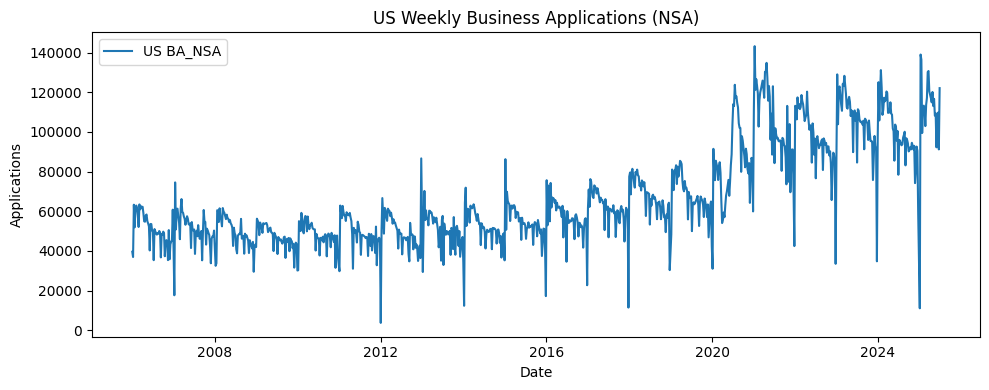

In [14]:
plt.figure(figsize=(10,4))
plt.plot(us.index, us['BA_NSA'], label='US BA_NSA')
plt.title('US Weekly Business Applications (NSA)')
plt.xlabel('Date')
plt.ylabel('Applications')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Correlation matrix
corr = us[['BA_NSA','HBA_NSA','WBA_NSA']].corr()
print("Correlation matrix:\n", corr)

Correlation matrix:
            BA_NSA   HBA_NSA   WBA_NSA
BA_NSA   1.000000  0.886696  0.264338
HBA_NSA  0.886696  1.000000  0.646679
WBA_NSA  0.264338  0.646679  1.000000


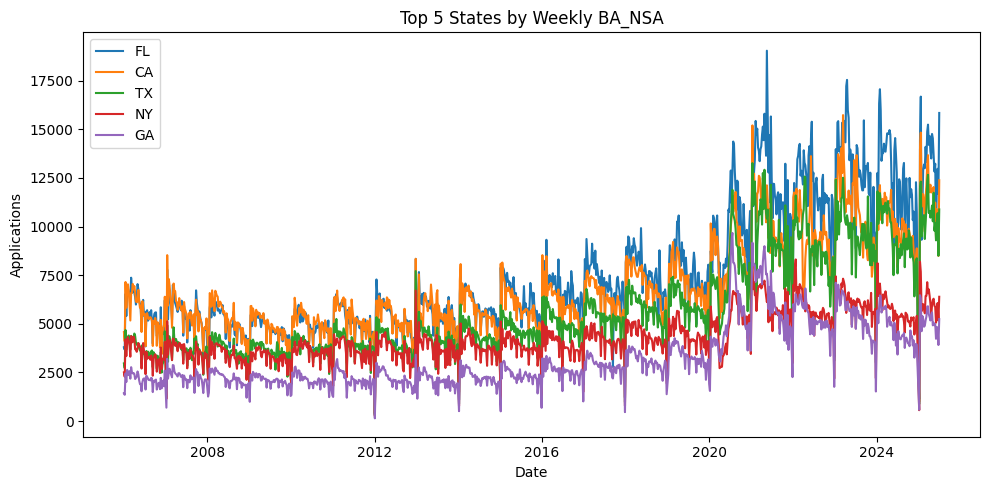

In [5]:
# Top 5 states trends
latest = df[df['date'] == df['date'].max()]
top5_states = latest.groupby('State')['BA_NSA'].sum().nlargest(5).index.tolist()

plt.figure(figsize=(10,5))
for state in top5_states:
    series = df[df['State']==state].set_index('date').sort_index()
    plt.plot(series.index, series['BA_NSA'], label=state)
plt.title('Top 5 States by Weekly BA_NSA')
plt.xlabel('Date'); plt.ylabel('Applications')
plt.legend(); plt.tight_layout(); plt.show()


In [6]:
us.head()

,BA_NSA,HBA_NSA,WBA_NSA
date,,,
2006-01-02,39580,22590,14960
2006-01-09,36920,23160,15840
2006-01-16,63300,37470,24480
2006-01-23,51910,30740,20270
2006-01-30,61430,35700,22820


## Innovative Insight
### Top 5 States were Florida, California, Texas, NewYork, and Georgia. These states rank among the most populous in the U.S., offering large and diverse customer bases that facilitate market entry and rapid customer acquisition for startups.

# 3. Data Preparation
### - Fullfill missing values (which doesn't happen this time) 
### - Create time index feature `days` (days since baseline)  
### - One-hot encode month and quarter  
### - Train/test split (first 80% as training)

In [7]:
# Time index feature
us['days'] = (us.index - us.index[0]).days

# One-hot encode month and quarter
us['month'] = us.index.month
us['quarter'] = us.index.quarter
us = pd.get_dummies(us, columns=['month','quarter'], drop_first=True)

# Define features and target
features = ['days','HBA_NSA','WBA_NSA'] + \
           [c for c in us.columns if c.startswith('month_') or c.startswith('quarter_')]
X = us[features]
y = us['BA_NSA']

# Split data
n_train = int(len(us)*0.8)
X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

# 4. Modeling
## Train three models:  
### - Simple linear regression on `days`  
### - Multiple linear regression on all features  
### - Decision tree regression

In [8]:
# (1) Simple linear regression
lr_simple = LinearRegression().fit(X_train[['days']], y_train)

# (2) Multiple linear regression
lr_multi  = LinearRegression().fit(X_train, y_train)

# (3) Decision tree regression
tree = DecisionTreeRegressor(max_depth=4, random_state=42).fit(X_train, y_train)

# 5. Evaluation
### - Calculate RMSE and MAE  
### - Examine feature importances and regression coefficients

In [9]:
models = {
    'Linear(days only)': (lr_simple, ['days']),
    'Linear(multi)': (lr_multi, features),
    'DecisionTree': (tree, features)
}

for name, (model, feats) in models.items():
    preds = model.predict(X_test[feats])
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Linear(days only) → RMSE: 25502.70, MAE: 22045.88
Linear(multi) → RMSE: 8852.98, MAE: 5612.33
DecisionTree → RMSE: 7517.34, MAE: 4707.77


In [10]:
# Feature importances
importances = pd.Series(tree.feature_importances_, index=features)
print("Decision Tree Feature Importances:\n", importances.sort_values(ascending=False))

Decision Tree Feature Importances:
 days         0.677471
HBA_NSA      0.318997
WBA_NSA      0.003532
month_2      0.000000
month_3      0.000000
month_4      0.000000
month_5      0.000000
month_6      0.000000
month_7      0.000000
month_8      0.000000
month_9      0.000000
month_10     0.000000
month_11     0.000000
month_12     0.000000
quarter_2    0.000000
quarter_3    0.000000
quarter_4    0.000000
dtype: float64


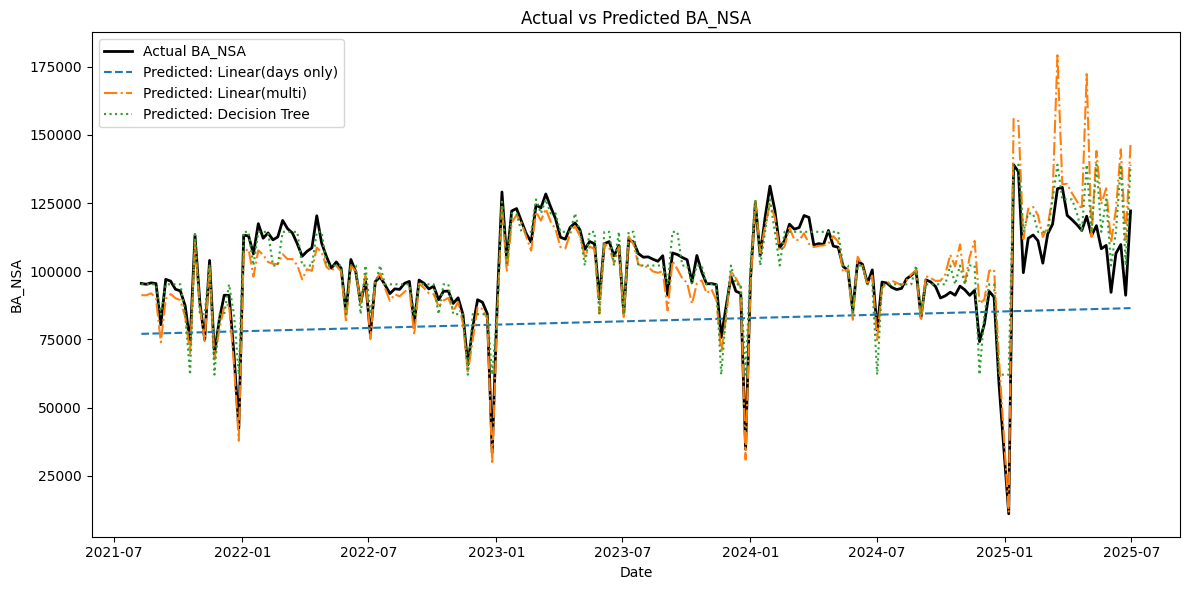

In [13]:
# Get predicted values to visualize
y_test_pred_simple = lr_simple.predict(X_test[['days']])
y_test_pred_multi = lr_multi.predict(X_test)
y_test_pred_tree = tree.predict(X_test)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual BA_NSA', color='black', linewidth=2)
plt.plot(y_test.index, y_test_pred_simple, label='Predicted: Linear(days only)', linestyle='--')
plt.plot(y_test.index, y_test_pred_multi, label='Predicted: Linear(multi)', linestyle='-.')
plt.plot(y_test.index, y_test_pred_tree, label='Predicted: Decision Tree', linestyle=':')

plt.title('Actual vs Predicted BA_NSA')
plt.xlabel('Date')
plt.ylabel('BA_NSA')
plt.legend()
plt.tight_layout()
plt.show()
